In [3]:
import pandas as pd
import numpy as np

import nfl_data_py as nfl

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
pbp = nfl.import_pbp_data(range(2016,2023))
pbp = pbp.loc[pbp['play_type'] == 'pass']
pbp = pbp.dropna(subset=['air_yards', 'passer_id'])
pbp.reset_index(inplace=True)
pbp.head()

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


,index,play_id,game_id,old_game_id_x,home_team,away_team,season_type,week,posteam,posteam_type,...,offense_players,defense_players,n_offense,n_defense,ngs_air_yards,time_to_throw,was_pressure,route,defense_man_zone_type,defense_coverage_type
0,3,85.0,2016_01_BUF_BAL,2016091101,BAL,BUF,REG,1,BAL,home,...,00-0029892;00-0027714;00-0032965;00-0029893;00...,00-0031171;00-0029542;00-0029566;00-0030073;00...,11.0,11.0,-4.53,2.404,0.0,FLAT,None,None
1,5,130.0,2016_01_BUF_BAL,2016091101,BAL,BUF,REG,1,BAL,home,...,00-0029892;00-0027714;00-0032965;00-0029893;00...,00-0029542;00-0031171;00-0029566;00-0030073;00...,11.0,11.0,1.71,2.093,0.0,FLAT,None,None
2,9,216.0,2016_01_BUF_BAL,2016091101,BAL,BUF,REG,1,BUF,away,...,00-0027004;00-0030046;00-0028112;00-0031325;00...,00-0031170;00-0027560;00-0027965;00-0031296;00...,11.0,10.0,1.61,2.537,0.0,ANGLE,None,None
3,11,261.0,2016_01_BUF_BAL,2016091101,BAL,BUF,REG,1,BUF,away,...,00-0027004;00-0030046;00-0028112;00-0031325;00...,00-0031170;00-0027560;00-0027965;00-0031296;00...,10.0,10.0,-3.46,2.265,0.0,SCREEN,None,None
4,13,310.0,2016_01_BUF_BAL,2016091101,BAL,BUF,REG,1,BAL,home,...,00-0027714;00-0032965;00-0029893;00-0026223;00...,00-0029542;00-0031171;00-0029566;00-0030073;00...,11.0,11.0,3.56,1.921,0.0,FLAT,None,None


In [5]:
pbp_pass = pbp.query('play_type == "pass" & passer_id.notnull() & air_yards.notnull()')
pbp_pass.reset_index(inplace=True)

In [6]:
pbp_pct = pbp_pass.query('0 < air_yards <= 20').groupby('air_yards').agg({'complete_pass': ['mean']})

pbp_pct.columns = list(map(''.join, pbp_pct.columns.values))

pbp_pct.reset_index(inplace=True)
pbp_pct.rename(columns={'complete_passmean': 'comp_pct'}, inplace=True)
pbp_pct.head()


,air_yards,comp_pct
0,1.0,0.765748
1,2.0,0.742391
2,3.0,0.724748
3,4.0,0.726399
4,5.0,0.716154


<Axes: xlabel='air_yards', ylabel='comp_pct'>

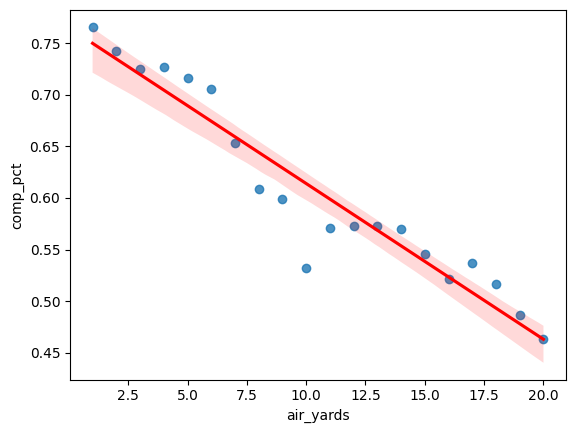

In [7]:
sns.regplot(x='air_yards', y='comp_pct', data=pbp_pct, line_kws={'color': 'red'})

In [8]:
complete_air_yards = smf.glm(
    formula='complete_pass ~ air_yards',
    data = pbp_pass,
    family=sm.families.Binomial()
).fit()

complete_air_yards.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          complete_pass   No. Observations:               131607
Model:                            GLM   Df Residuals:                   131605
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -81066.
Date:                Sat, 23 Nov 2024   Deviance:                   1.6213e+05
Time:                        16:25:30   Pearson chi2:                 1.32e+05
No. Iterations:                     5   Pseudo R-squ. (CS):            0.07025
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0727      0.008    133.348      0.000       1.057       1.088
air_yards     -0.0574      0.001    -91.880      0.000      -0.059      -0.056
==============================================================================
"""

<Axes: xlabel='air_yards', ylabel='complete_pass'>

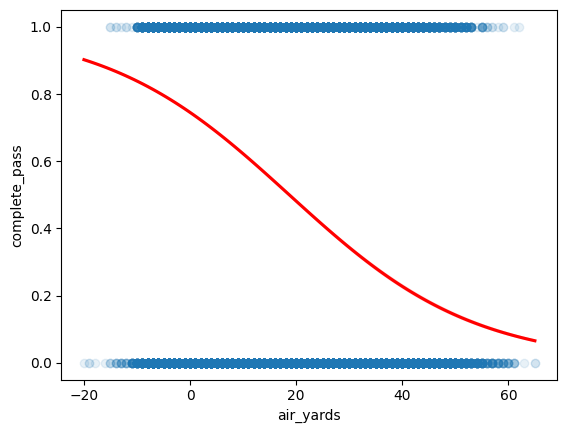

In [9]:
sns.regplot(
    data=pbp_pass,
    x='air_yards',
    y='complete_pass',
    logistic=True,
    line_kws={'color': 'red'},
    scatter_kws={'alpha': 0.1}
)

In [ ]:
pbp_pass['exp_completion'] = complete_air_yards.predict()

pbp_pass['cpoe'] = pbp_pass['complete_pass'] - pbp_pass['exp_completion']

In [15]:
cpoe = pbp_pass \
    .groupby(['season', 'passer_id', 'passer']) \
    .agg({
        'cpoe': ['mean', 'count'],
        'complete_pass': ['mean']
    })

cpoe.columns = list(map(''.join, cpoe.columns.values))
cpoe.reset_index(inplace=True)

cpoe = cpoe.rename(columns={
    'cpoemean': 'cpoe',
    'cpoecount': 'n',
    'complete_passmean': 'compl'
}).query('n > 100')

cpoe.sort_values('cpoe', ascending=False).head(10)

,season,passer_id,passer,cpoe,n,compl
22,2016,00-0026143,M.Ryan,7.142148,624,0.702060
328,2019,00-0029263,R.Wilson,7.102611,550,0.663176
228,2018,00-0029263,R.Wilson,7.059012,427,0.668161
465,2020,00-0033357,T.Hill,6.811872,118,0.727273
407,2020,00-0023459,A.Rodgers,6.779110,581,0.705107
467,2020,00-0033537,D.Watson,6.522549,523,0.704797
334,2019,00-0029701,R.Tannehill,6.361813,337,0.690962
299,2019,00-0020531,D.Brees,6.196604,397,0.756158
157,2017,00-0031345,J.Garoppolo,6.005949,176,0.681818
193,2018,00-0020531,D.Brees,5.999808,557,0.738516


In [16]:
pbp_pass['down'] = pbp_pass['down'].astype(str)
pbp_pass['qb_hit'] = pbp_pass['qb_hit'].astype(str)

pbp_pass_no_miss = pbp_pass[[
    'passer',
    'passer_id',
    'season',
    'down',
    'qb_hit',
    'complete_pass',
    'ydstogo',
    'yardline_100',
    'air_yards',
    'pass_location'
]].dropna(axis=0)

In [17]:
complete_more = smf.glm(
    formula='complete_pass ~ down + qb_hit + ydstogo + yardline_100 + air_yards + pass_location',
    data=pbp_pass_no_miss,
    family=sm.families.Binomial()
).fit()

In [18]:
pbp_pass_no_miss['exp_completion'] = complete_more.predict()
pbp_pass_no_miss['cpoe'] = pbp_pass_no_miss['complete_pass'] - pbp_pass_no_miss['exp_completion']

In [19]:
cpoe_more = pbp_pass_no_miss \
    .groupby(['season', 'passer_id', 'passer']) \
    .agg({
        'cpoe': ['mean', 'count'],
        'complete_pass': ['mean'],
        'exp_completion': ['mean']
    })

cpoe_more.columns = list(map(''.join, cpoe_more.columns.values))

cpoe_more.reset_index(inplace=True)

cpoe_more = cpoe_more.rename(columns={
    'cpoemean': 'cpoe',
    'cpoecount': 'n',
    'complete_passmean': 'compl',
    'exp_completionmean': 'exp_completion'
}).query('n > 100')

cpoe_more.sort_values('cpoe', ascending=False).head(10)

,season,passer_id,passer,cpoe,n,compl,exp_completion
193,2018,00-0020531,D.Brees,0.088787,566,0.738516,0.649729
299,2019,00-0020531,D.Brees,0.087599,406,0.756158,0.668559
465,2020,00-0033357,T.Hill,0.082524,121,0.727273,0.644748
22,2016,00-0026143,M.Ryan,0.077726,631,0.702060,0.624334
467,2020,00-0033537,D.Watson,0.072926,542,0.704797,0.631871
334,2019,00-0029701,R.Tannehill,0.066572,343,0.690962,0.624390
31,2016,00-0027854,S.Bradford,0.061547,551,0.716878,0.655331
407,2020,00-0023459,A.Rodgers,0.061488,607,0.705107,0.643619
204,2018,00-0023682,R.Fitzpatrick,0.061465,246,0.666667,0.605202
208,2018,00-0026143,M.Ryan,0.059813,607,0.695222,0.635409


In [20]:
cols = ['season', 'passer_id', 'passer', 'cpoe', 'compl', 'exp_completion']

cpoe_now = cpoe_more[cols].copy()
cpoe_last = cpoe_now[cols].copy()

cpoe_last.rename(columns={
    'cpoe': 'cpoe_last',
    'compl': 'compl_last',
    'exp_completion': 'exp_completion_last'
}, inplace=True)

cpoe_now['season'] = cpoe_now['season'] + 1

cpoe_lag = cpoe_now.merge(cpoe_last, on=['passer_id', 'passer', 'season'], how='inner')

In [22]:
cpoe_lag[['compl_last', 'compl']].corr()

,compl_last,compl
compl_last,1.00000,0.44578
compl,0.44578,1.00000


In [23]:
cpoe_lag[['cpoe_last', 'cpoe']].corr()

,cpoe_last,cpoe
cpoe_last,1.000000,0.467622
cpoe,0.467622,1.000000
